In [2]:
%load_ext autoreload
%autoreload 2

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize
from lineplots import plotsd
from session_utils import *
from recalibration_utils import *
from click_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files          = glob.glob('D:/T5_ClosedLoop/*')
sessions_check = np.load('misc_data/sessions_check.npy', allow_pickle = True).item()


min_nblocks    = 3                                 # min number of blocks for a session to be include
sessions       = get_Sessions(files, min_nblocks)  # get T5 sessions      

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
print(len(sessions))

61


In [14]:
from sklearn.metrics import r2_score
from CosineTuning import angle_between

train_frac = 0.5
task       = None
sigma      = 2

test_scores    = np.zeros((len(files), 2))
decoding_angle = np.zeros((len(files), 3))

for i, f in enumerate(files):
    day        = DataStruct(f, alignScreens = True)
    blocks     = [sessions_check[f] if f in sessions_check.keys() else None][0]

    train_x, test_x, train_y, test_y  = getTrainTest(day, train_frac = train_frac, sigma = sigma, task = task, blocks = blocks, return_flattened = True)
    train_mags, test_mags             = np.linalg.norm(train_y, axis = 1), np.linalg.norm(test_y, axis = 1)

    means       = train_x.mean(axis = 0)
    veldecoder  = LinearRegression(normalize = False).fit(train_x, train_y)
    
    magdecoder  = LinearRegression(normalize = False).fit(train_x, train_mags)
    mag_preds   = magdecoder.predict(test_x)
    
    vel_preds   = veldecoder.predict(test_x)
    unit_preds  = vel_preds / np.linalg.norm(vel_preds, axis = 1)[:, np.newaxis]
    preds       = unit_preds * mag_preds[:, np.newaxis]
    
    test_scores[i, 0] = r2_score(test_y, vel_preds)
    test_scores[i, 1] = r2_score(test_y, preds)
    
    decoding_angle[i, 0] = angle_between(magdecoder.coef_,    veldecoder.coef_[0, :])     # angle between X-velocity decoder and magnitude decoder 
    decoding_angle[i, 1] = angle_between(magdecoder.coef_,    veldecoder.coef_[1, :])     # angle between Y-velocity decoder and magnitude decoder
    decoding_angle[i, 2] = angle_between(veldecoder.coef_[0, :], veldecoder.coef_[1, :])  # angle between X-velocity and Y-velocity decoder 

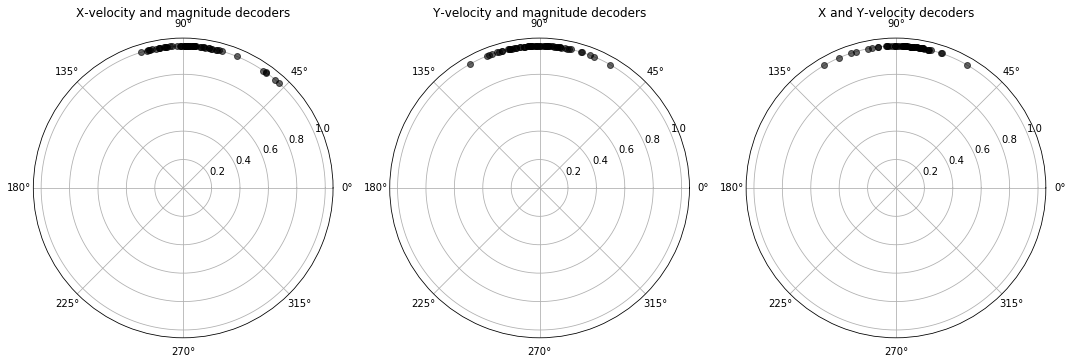

In [17]:
figSize(5, 15)

titles = ['X-velocity and magnitude decoders', 'Y-velocity and magnitude decoders', 'X and Y-velocity decoders']
for i in range(3):
    plt.subplot(1, 3, i + 1, projection = 'polar')
    plt.title(titles[i])
    for j in range(len(sessions)):
        plt.polar(decoding_angle[j, i], 1, 'ro', color = 'k', alpha = 0.6)
        
plt.tight_layout()

NameError: name 'sessions' is not defined

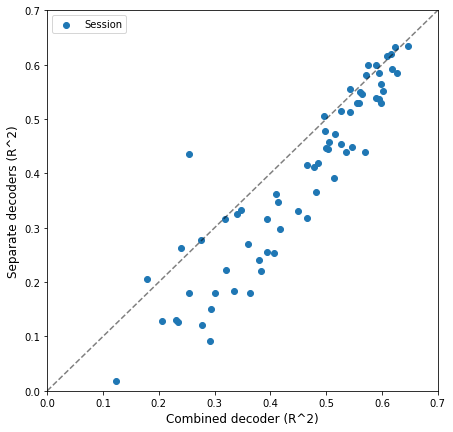

In [21]:
figSize(7, 7)
ax_lims = [0, 0.7]

plt.scatter(test_scores[:, 0], test_scores[:, 1], label = 'Session')
plt.plot(ax_lims, ax_lims, color = 'k', linestyle = '--', alpha = 0.5)
plt.xlim(ax_lims)
plt.ylim(ax_lims)
plt.xlabel('Combined decoder (R^2)', fontsize = 12)
plt.ylabel('Separate decoders (R^2)', fontsize = 12)
plt.legend()